## Importar lo importante

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
from aux_functions_comparisson import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations
import random
import scipy as sp

## Obtener datos

In [2]:
with open('data/shared_rois.pickle') as f:
    shared_rois = pickle.load(f)

In [3]:
with open('data/feature_data.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [4]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [5]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

In [6]:
shared_1_rois_2_month = 0
shared_2_rois_2_month = 0
for i in range(limit):
    if shared_rois[i,i] > 0:
        shared_1_rois_2_month += 1
    if shared_rois[i,i] > 1:
        shared_2_rois_2_month += 1
print "% de tarjetas que comparten un roi en ambos meses:",str(round(shared_1_rois_2_month*100/limit,2)) + "%"
print "% de tarjetas que comparten dos roi en ambos meses:", str(round(shared_2_rois_2_month*100/limit,2)) + "%"

% de tarjetas que comparten un roi en ambos meses: 93.38%
% de tarjetas que comparten dos roi en ambos meses: 54.85%


### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [7]:
n_of_neighbours = []
for i in range(limit):
    n_of_neighbours.append(len(get_neighbours_index(abril_the_rois,shared_rois,i,2)))

(array([ 1051.,  1642.,   808.,   431.,   263.,   191.,   116.,    91.,
          117.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

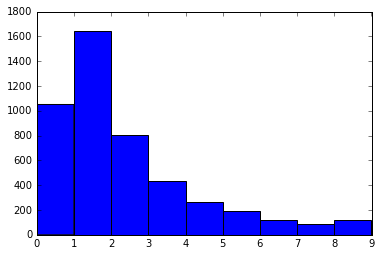

In [8]:
plt.hist(n_of_neighbours,range(10))

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [9]:
n10_of_neighbours = filter(lambda x: x>9,n_of_neighbours)

(array([ 269.,  109.,   36.,    8.,    8.,    8.,    5.,    4.,    1.,
           0.,    0.,    1.,    2.,    1.,    0.,    0.,    0.,    0.,
           1.,    0.,    2.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    0.,    1.]),
 array([  10.        ,   19.06666667,   28.13333333,   37.2       ,
          46.26666667,   55.33333333,   64.4       ,   73.46666667,
          82.53333333,   91.6       ,  100.66666667,  109.73333333,
         118.8       ,  127.86666667,  136.93333333,  146.        ,
         155.06666667,  164.13333333,  173.2       ,  182.26666667,
         191.33333333,  200.4       ,  209.46666667,  218.53333333,
         227.6       ,  236.66666667,  245.73333333,  254.8       ,
         263.86666667,  272.93333333,  282.        ]),
 <a list of 30 Patch objects>)

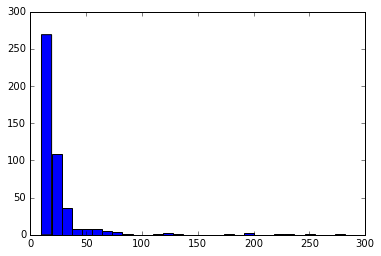

In [10]:
plt.hist(n10_of_neighbours,30)

## Feature Exploration

In [11]:
N_FEATURES = 19

In [12]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [13]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

## Seleccionar Features para la comparación

In [14]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin",\
    "start_time","end_time","traveled_days","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]


In [15]:
abril_selected_features = filter_features(abril_vectors,selected_features,features_dict)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features,features_dict)

### Seleccionar con distancia euclidiana y similitud braycurtis entre los vecinos con las features ya normalizadas con min max

In [16]:
abril_norm_vectors = np.ones((limit, N_FEATURES))
septiembre_norm_vectors = np.ones((limit, N_FEATURES))
for i in range(abril_selected_features.shape[1]):
    abril_norm_vectors[:,i] = normalizar_min_max(abril_selected_features[:,i])
    septiembre_norm_vectors[:,i] = normalizar_min_max(septiembre_selected_features[:,i])

In [17]:
a_matrix_euclidiana = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,abril_the_rois,\
                                           septiembre_the_rois,shared_rois,limit,2,sp.spatial.distance.euclidean)
n_identified_e,selected_distance_e,identified_indexs_e,abstenidos_e = get_n_correct(a_matrix_euclidiana,limit)
porcentaje_correcto = n_identified_e*100/limit
print "Dist Euclidiana con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"
print "Falsos positivos: "+ str(((limit-n_identified_e-len(abstenidos_e))*100/limit)) + "%"
print "Falsos negativos: "+ str(len(abstenidos_e)*100/limit) + "%"

0.640876054764
Dist Euclidiana con norma minmax general: 45.15%
Falsos positivos: 31.8049912943%
Falsos negativos: 23.0412071967%


In [18]:
a_matrix_braycurtis = compare_vectors_with_neighbours_normalized(abril_norm_vectors,septiembre_norm_vectors,\
                                                     abril_the_rois,septiembre_the_rois,shared_rois,limit,2,\
                                                     sp.spatial.distance.braycurtis)
n_identified_b,selected_distance_b,identified_indexs_b,abstenidos_b = get_n_correct(a_matrix_braycurtis,limit)
porcentaje_correcto = n_identified_b*100/limit
print "Dist braycurtis con norma minmax general: "+str(round(porcentaje_correcto,2))+ "%"
print "Falsos positivos: "+ str(((limit-n_identified_b-len(abstenidos_b))*100/limit)) + "%"
print "Falsos negativos: "+ str(len(abstenidos_b)*100/limit) + "%"

0.531034946442
Dist braycurtis con norma minmax general: 46.28%
Falsos positivos: 33.3913716386%
Falsos negativos: 20.3327529503%


### Ver si son los mismos seleccionados

In [19]:
corr_in_both = []
abst_in_both = []
wrong_in_both = []
corr_id_in_e = []
corr_id_in_b = []
wrong_id_in_e = []
wrong_id_in_b = []
for i in range(limit):
    if identified_indexs_b[i] == identified_indexs_e[i]:
        if identified_indexs_b[i] == -1:
            abst_in_both.append(i)
        elif identified_indexs_b[i] == i:
            corr_in_both.append(i)
        else:
            wrong_in_both.append(i)
    elif identified_indexs_b[i] != identified_indexs_e[i]:
        if  identified_indexs_b[i] == -1 and identified_indexs_e[i] == i:
            corr_id_in_e.append(i)
        elif identified_indexs_b[i] == -1:
            wrong_id_in_e.append(i)
        elif identified_indexs_e[i] == -1 and identified_indexs_b[i] == i:
            corr_id_in_b.append(i)
        else:
            wrong_id_in_b.append(i)
            

In [20]:
print "Ambos correctos: "+ str(len(corr_in_both))
print "Ambos incorrectos: "+ str(len(wrong_in_both))
print "Ambos abstenidos: "+ str(len(abst_in_both))
print "Porcentaje en ambos igual: "+ str((len(corr_in_both)+len(wrong_in_both)+len(abst_in_both))*100/limit)

Ambos correctos: 2299
Ambos incorrectos: 1414
Ambos abstenidos: 1051
Porcentaje en ambos igual: 92.164828787


In [21]:
print "Correcto con euclidiana y abstenido con braycurtis: "+ str(len(corr_id_in_e))
print "Incorrecto con euclidiana y abstenido con braycurtis: "+ str(len(wrong_id_in_e))
print "Correcto con braycurtis y abstenido con euclidiana: "+ str(len(corr_id_in_b))
print "Incorrecto con braycurtis y abstenido con euclidiana: "+ str(len(wrong_id_in_b))


Correcto con euclidiana y abstenido con braycurtis: 0
Incorrecto con euclidiana y abstenido con braycurtis: 0
Correcto con braycurtis y abstenido con euclidiana: 15
Incorrecto con braycurtis y abstenido con euclidiana: 390


### Ver en que orden queda el vector correcto

In [78]:
def get_position_right_answer(distance_matrix):
    positions = []
    n_neighbours = []
    n_n_correct = []
    neighbours_distances = []
    limit = len(distance_matrix)
    result = []
    possible_same_person = []
    for i in range(limit):
        neighbours = np.where(distance_matrix[i] != -1)[0]
        the_index = np.argmax(distance_matrix[i,:])
        neighbours_distances = []
        if distance_matrix[i,the_index] == -1:
            continue
        num_neighbours = len(neighbours)
        if distance_matrix[i,i] == -1:
            if num_neighbours == 1:
                possible_same_person.append([i,the_index])
            continue
        if num_neighbours > 0:
            if i != the_index:
                for j in neighbours:
                    neighbours_distances.append(distance_matrix[i,j])
                sorted_neighbours = np.sort(neighbours_distances)
                #positions.append(np.where(sorted_neighbours==distance_matrix[i,i]))
                n_neighbours.append(num_neighbours)
                result.append((distance_matrix[i,i],np.where(sorted_neighbours==distance_matrix[i,i])[0][0],num_neighbours))
            else:
                n_n_correct.append(num_neighbours)
    #return positions,n_neighbours
    return [result,n_neighbours,n_n_correct,possible_same_person]

In [79]:
p,n_n_fail,n_n_correct,p_s_p = get_position_right_answer(a_matrix_braycurtis)

In [80]:
len(n_n_correct)*100/limit

46.275875411104664

(array([  0.,   0.,  57.,  57.,  48.,  43.,  29.,  22.,  14.,   6.,  18.,
         16.,  14.,   7.,  12.,   6.,   6.,   3.,   5.,   5.,   8.,   3.,
          4.,   4.,   4.,   5.,   3.,   4.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

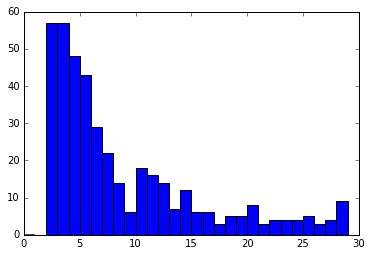

In [81]:
plt.hist(n_n_fail,range(30))

(array([  0.00000000e+00,   1.17500000e+03,   5.07000000e+02,
          2.28000000e+02,   1.31000000e+02,   8.40000000e+01,
          5.20000000e+01,   3.30000000e+01,   2.40000000e+01,
          2.50000000e+01,   2.00000000e+01,   1.50000000e+01,
          9.00000000e+00,   5.00000000e+00,   1.10000000e+01,
          8.00000000e+00,   4.00000000e+00,   7.00000000e+00,
          6.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   3.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

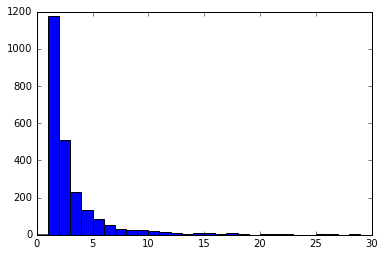

In [82]:
plt.hist(n_n_correct,range(30))

In [83]:
penultimo_3 = 0
penultimo_4 = 0
penultimo_5m = 0
only_two = 0
no_penultimo = 0
tercero = 0
for atuple in p:
    if atuple[2] == 2:
        only_two += 1
    elif atuple[2] == 3 and atuple[2]-2 == atuple[1]:
        penultimo_3 += 1
    elif atuple[2] == 4 and atuple[2]-2 == atuple[1]:
        penultimo_4 += 1
    elif atuple[2]-2 == atuple[1]:
        penultimo_5m += 1
    else: 
        if atuple[2]-3 == atuple[1]:
            tercero += 1
        else: 
            no_penultimo +=1
print "Solo dos opciones, ",only_two*100/len(p)
print "Penultimo de 3, ",penultimo_3*100/len(p)
print "Penultimo de 4, ",penultimo_4*100/len(p)
print "Penultimod de 5 o mas, ",penultimo_5m*100/len(p)
print "Tercero de 5 o mas, ",tercero*100/len(p)
print "Ni tercero, ",no_penultimo*100/len(p)


Solo dos opciones,  12.8668171558
Penultimo de 3,  9.7065462754
Penultimo de 4,  5.19187358916
Penultimod de 5 o mas,  27.3137697517
Tercero de 5 o mas,  15.8013544018
Ni tercero,  29.1196388262


In [85]:
len(p_s_p)

467

In [118]:
num_matches = []
counter = 0
for n in p_s_p:
    n_matches = 0
    for n2 in p_s_p:
        if n2[1] == n[0] and n2[0] == n[1]:
            n_matches += 1
    num_matches.append(n_matches)
    counter += 1

(array([   0.,    0.,    0.,    0.,    0.,  467.,    0.,    0.,    0.,    0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

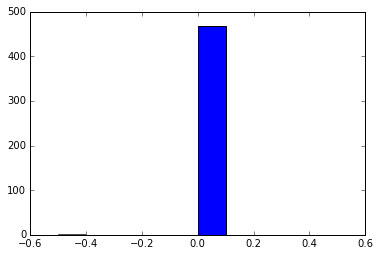

In [119]:
plt.hist(num_matches)